<a href="https://colab.research.google.com/github/Sargam2808/Computer-Vision-project/blob/main/Dl_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch torchvision tqdm seaborn scikit-learn


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [5]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

classes = train_data.classes


100%|██████████| 170M/170M [07:36<00:00, 373kB/s]


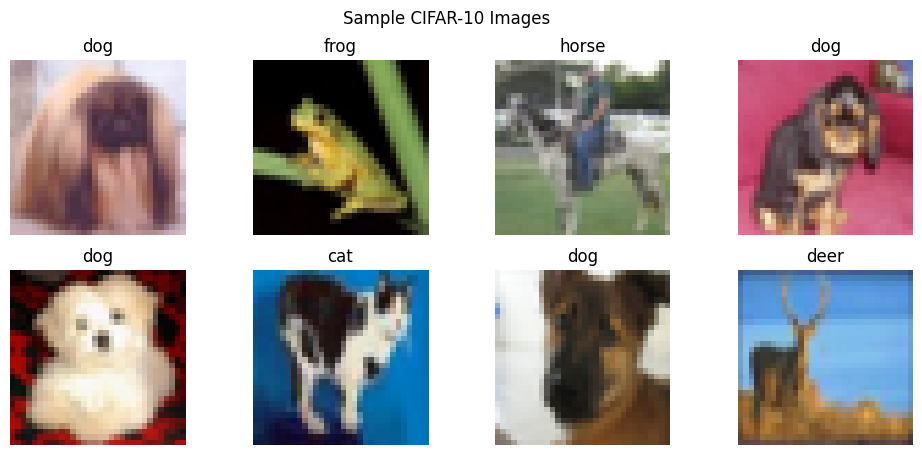

In [6]:
def show_images():
    images, labels = next(iter(train_loader))
    images, labels = images[:8], labels[:8]

    plt.figure(figsize=(12,5))
    for i in range(8):
        plt.subplot(2,4,i+1)
        img = images[i] * 0.5 + 0.5
        plt.imshow(np.transpose(img.numpy(), (1,2,0)))
        plt.title(classes[labels[i]])
        plt.axis("off")

    plt.suptitle("Sample CIFAR-10 Images")
    plt.show()

show_images()


In [7]:
class CNN(nn.Module):
    def __init__(self, activation):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 10)

        if activation == "relu":
            self.act = nn.ReLU()
        elif activation == "tanh":
            self.act = nn.Tanh()
        elif activation == "leakyrelu":
            self.act = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.act(self.fc1(x)))
        return self.fc2(x)


In [8]:
def init_weights(model, method):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            if method == "random":
                nn.init.uniform_(m.weight)
            elif method == "xavier":
                nn.init.xavier_uniform_(m.weight)
            elif method == "kaiming":
                nn.init.kaiming_uniform_(m.weight)


In [9]:
def train_model(model, optimizer, criterion, epochs=5):
    model.train()
    losses = []

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    return losses


In [10]:
def evaluate_model(model):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    acc = 100 * correct / total
    return acc



Activation=relu, Init=random, Optimizer=sgd


100%|██████████| 782/782 [01:24<00:00,  9.24it/s]


Epoch 1, Loss: 5455.3201


100%|██████████| 782/782 [01:24<00:00,  9.27it/s]


Epoch 2, Loss: 2.3028


100%|██████████| 782/782 [01:25<00:00,  9.10it/s]


Epoch 3, Loss: 2.3027


100%|██████████| 782/782 [01:28<00:00,  8.86it/s]


Epoch 4, Loss: 2.3027


100%|██████████| 782/782 [01:24<00:00,  9.26it/s]


Epoch 5, Loss: 2.3027


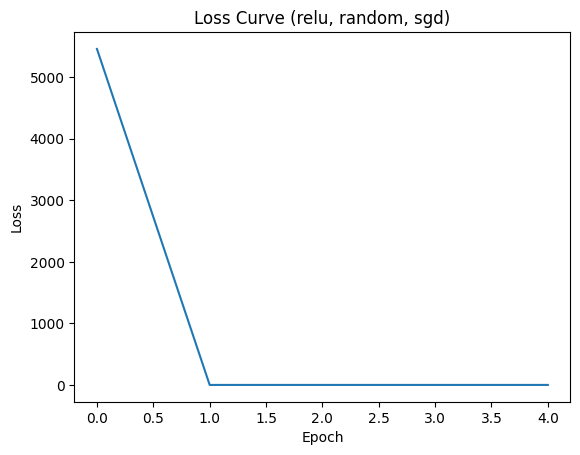


Activation=relu, Init=random, Optimizer=adam


100%|██████████| 782/782 [01:29<00:00,  8.78it/s]


Epoch 1, Loss: 635010.4903


100%|██████████| 782/782 [01:35<00:00,  8.21it/s]


Epoch 2, Loss: 2684.6086


100%|██████████| 782/782 [01:33<00:00,  8.32it/s]


Epoch 3, Loss: 142.4879


100%|██████████| 782/782 [01:29<00:00,  8.75it/s]


Epoch 4, Loss: 48.1385


100%|██████████| 782/782 [01:30<00:00,  8.67it/s]


Epoch 5, Loss: 23.6349


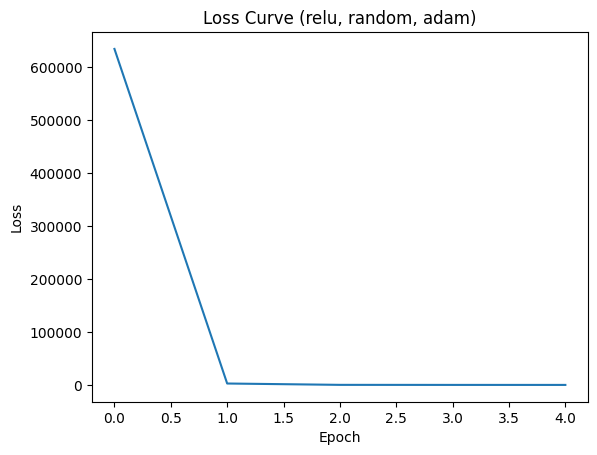


Activation=relu, Init=random, Optimizer=rmsprop


100%|██████████| 782/782 [01:31<00:00,  8.53it/s]


Epoch 1, Loss: 333037.6320


100%|██████████| 782/782 [01:28<00:00,  8.79it/s]


Epoch 2, Loss: 46.7475


100%|██████████| 782/782 [01:25<00:00,  9.10it/s]


Epoch 3, Loss: 2.7498


100%|██████████| 782/782 [01:25<00:00,  9.10it/s]


Epoch 4, Loss: 2.3045


100%|██████████| 782/782 [01:29<00:00,  8.74it/s]


Epoch 5, Loss: 2.2556


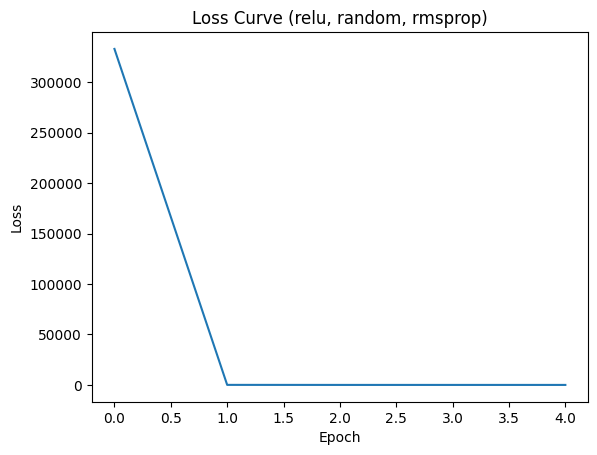


Activation=relu, Init=xavier, Optimizer=sgd


100%|██████████| 782/782 [01:33<00:00,  8.37it/s]


Epoch 1, Loss: 1.9290


100%|██████████| 782/782 [01:32<00:00,  8.45it/s]


Epoch 2, Loss: 1.6061


100%|██████████| 782/782 [01:33<00:00,  8.40it/s]


Epoch 3, Loss: 1.4434


100%|██████████| 782/782 [01:33<00:00,  8.40it/s]


Epoch 4, Loss: 1.3445


100%|██████████| 782/782 [01:33<00:00,  8.39it/s]


Epoch 5, Loss: 1.2809


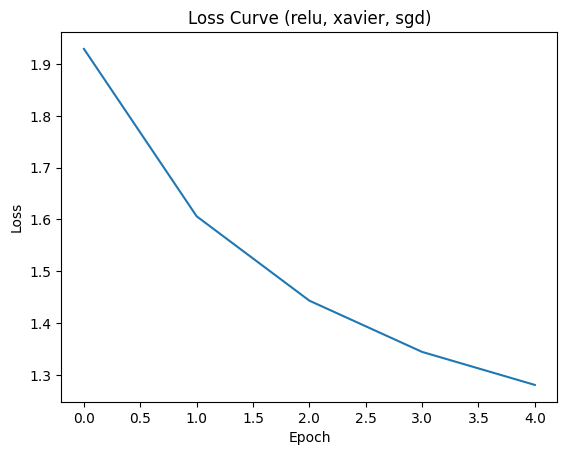


Activation=relu, Init=xavier, Optimizer=adam


100%|██████████| 782/782 [01:34<00:00,  8.24it/s]


Epoch 1, Loss: 1.4118


100%|██████████| 782/782 [01:39<00:00,  7.85it/s]


Epoch 2, Loss: 1.0663


100%|██████████| 782/782 [01:38<00:00,  7.92it/s]


Epoch 3, Loss: 0.9393


100%|██████████| 782/782 [01:37<00:00,  8.04it/s]


Epoch 4, Loss: 0.8549


100%|██████████| 782/782 [01:35<00:00,  8.16it/s]


Epoch 5, Loss: 0.7919


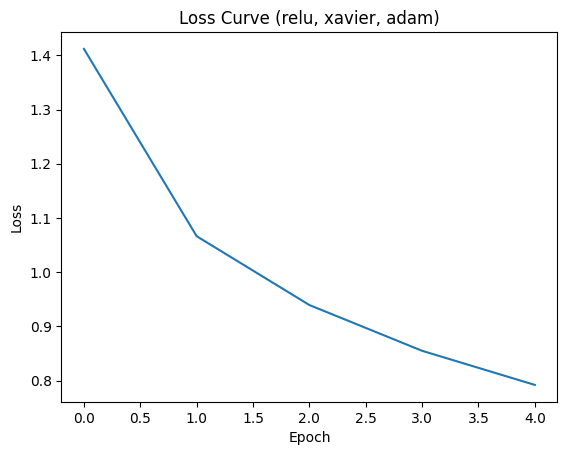


Activation=relu, Init=xavier, Optimizer=rmsprop


100%|██████████| 782/782 [01:32<00:00,  8.41it/s]


Epoch 1, Loss: 1.4812


100%|██████████| 782/782 [01:36<00:00,  8.14it/s]


Epoch 2, Loss: 1.0902


100%|██████████| 782/782 [01:33<00:00,  8.39it/s]


Epoch 3, Loss: 0.9563


100%|██████████| 782/782 [01:31<00:00,  8.50it/s]


Epoch 4, Loss: 0.8737


100%|██████████| 782/782 [01:33<00:00,  8.32it/s]


Epoch 5, Loss: 0.8112


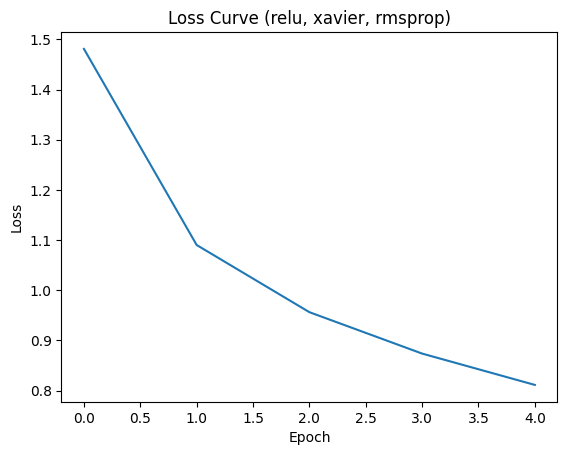


Activation=relu, Init=kaiming, Optimizer=sgd


100%|██████████| 782/782 [01:33<00:00,  8.35it/s]


Epoch 1, Loss: 1.7648


100%|██████████| 782/782 [01:33<00:00,  8.38it/s]


Epoch 2, Loss: 1.4548


100%|██████████| 782/782 [01:35<00:00,  8.21it/s]


Epoch 3, Loss: 1.3232


100%|██████████| 782/782 [01:33<00:00,  8.37it/s]


Epoch 4, Loss: 1.2391


100%|██████████| 782/782 [01:32<00:00,  8.47it/s]


Epoch 5, Loss: 1.1682


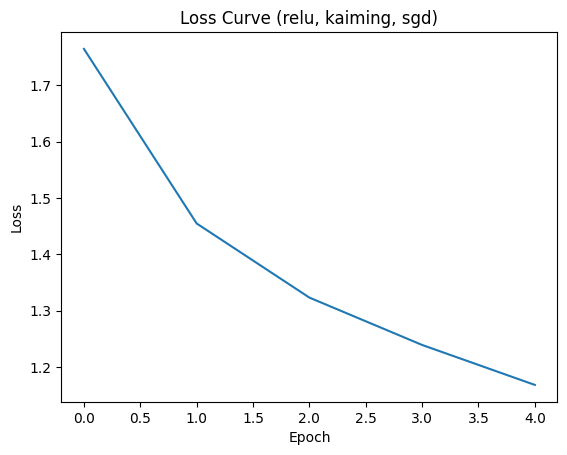


Activation=relu, Init=kaiming, Optimizer=adam


100%|██████████| 782/782 [01:35<00:00,  8.16it/s]


Epoch 1, Loss: 1.4782


100%|██████████| 782/782 [01:38<00:00,  7.94it/s]


Epoch 2, Loss: 1.1129


100%|██████████| 782/782 [01:40<00:00,  7.79it/s]


Epoch 3, Loss: 0.9883


100%|██████████| 782/782 [01:39<00:00,  7.85it/s]


Epoch 4, Loss: 0.8944


100%|██████████| 782/782 [01:38<00:00,  7.95it/s]


Epoch 5, Loss: 0.8411


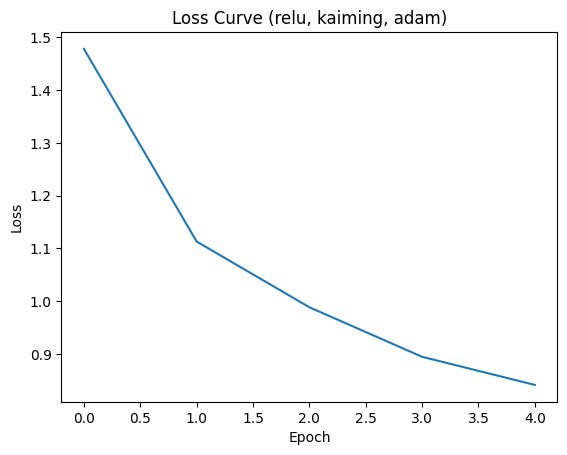


Activation=relu, Init=kaiming, Optimizer=rmsprop


100%|██████████| 782/782 [01:35<00:00,  8.21it/s]


Epoch 1, Loss: 1.4705


100%|██████████| 782/782 [01:36<00:00,  8.09it/s]


Epoch 2, Loss: 1.0550


100%|██████████| 782/782 [01:32<00:00,  8.43it/s]


Epoch 3, Loss: 0.9239


100%|██████████| 782/782 [01:33<00:00,  8.39it/s]


Epoch 4, Loss: 0.8396


100%|██████████| 782/782 [01:31<00:00,  8.56it/s]


Epoch 5, Loss: 0.7747


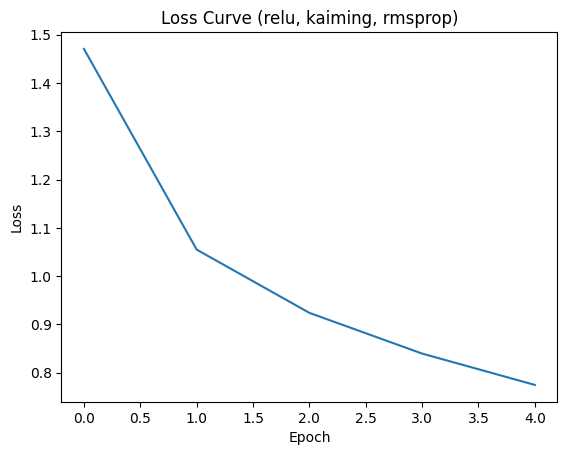


Activation=tanh, Init=random, Optimizer=sgd


100%|██████████| 782/782 [01:33<00:00,  8.35it/s]


Epoch 1, Loss: 3.4335


100%|██████████| 782/782 [01:34<00:00,  8.25it/s]


Epoch 2, Loss: 3.0389


100%|██████████| 782/782 [01:35<00:00,  8.22it/s]


Epoch 3, Loss: 2.7997


100%|██████████| 782/782 [01:34<00:00,  8.26it/s]


Epoch 4, Loss: 2.6115


100%|██████████| 782/782 [01:38<00:00,  7.94it/s]


Epoch 5, Loss: 2.4839


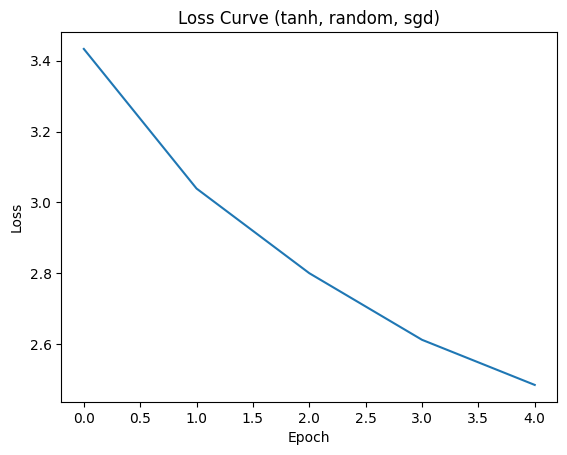


Activation=tanh, Init=random, Optimizer=adam


100%|██████████| 782/782 [01:40<00:00,  7.81it/s]


Epoch 1, Loss: 3.3115


100%|██████████| 782/782 [01:37<00:00,  7.99it/s]


Epoch 2, Loss: 2.7519


100%|██████████| 782/782 [01:38<00:00,  7.96it/s]


Epoch 3, Loss: 2.4633


100%|██████████| 782/782 [01:42<00:00,  7.64it/s]


Epoch 4, Loss: 2.3433


100%|██████████| 782/782 [01:37<00:00,  7.99it/s]


Epoch 5, Loss: 2.2974


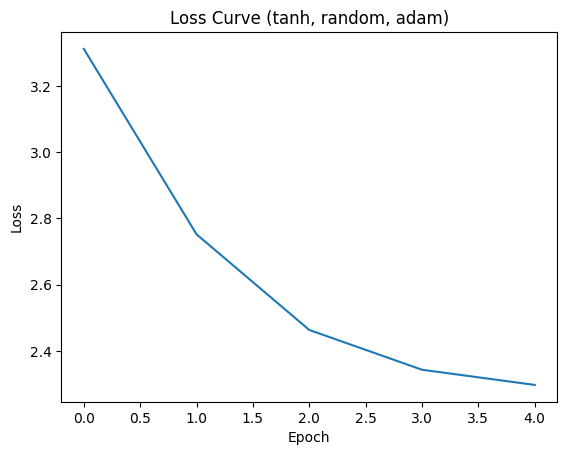


Activation=tanh, Init=random, Optimizer=rmsprop


100%|██████████| 782/782 [01:36<00:00,  8.11it/s]


Epoch 1, Loss: 3.3085


100%|██████████| 782/782 [01:34<00:00,  8.27it/s]


Epoch 2, Loss: 2.7354


100%|██████████| 782/782 [01:37<00:00,  8.05it/s]


Epoch 3, Loss: 2.4461


100%|██████████| 782/782 [01:37<00:00,  8.06it/s]


Epoch 4, Loss: 2.3281


100%|██████████| 782/782 [01:35<00:00,  8.23it/s]


Epoch 5, Loss: 2.2866


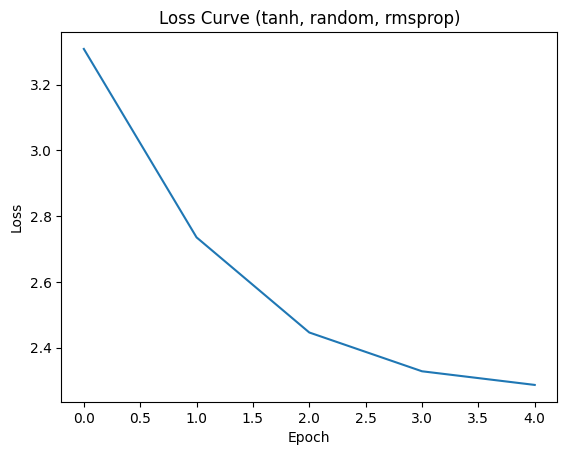


Activation=tanh, Init=xavier, Optimizer=sgd


100%|██████████| 782/782 [01:40<00:00,  7.81it/s]


Epoch 1, Loss: 1.7631


100%|██████████| 782/782 [01:41<00:00,  7.72it/s]


Epoch 2, Loss: 1.5035


100%|██████████| 782/782 [01:40<00:00,  7.81it/s]


Epoch 3, Loss: 1.3715


100%|██████████| 782/782 [01:40<00:00,  7.77it/s]


Epoch 4, Loss: 1.2646


100%|██████████| 782/782 [01:42<00:00,  7.61it/s]


Epoch 5, Loss: 1.1900


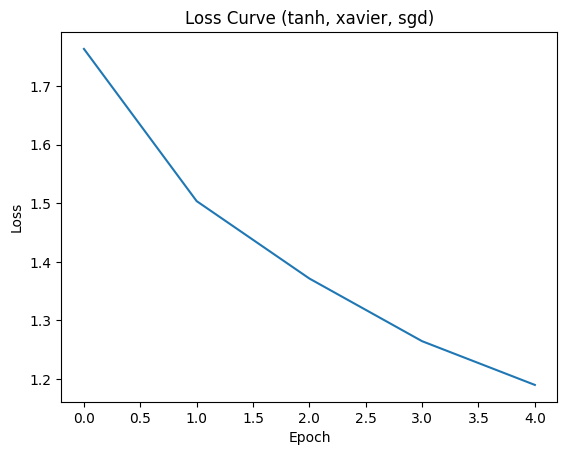


Activation=tanh, Init=xavier, Optimizer=adam


100%|██████████| 782/782 [01:44<00:00,  7.50it/s]


Epoch 1, Loss: 1.3204


100%|██████████| 782/782 [01:44<00:00,  7.52it/s]


Epoch 2, Loss: 1.0612


100%|██████████| 782/782 [01:44<00:00,  7.48it/s]


Epoch 3, Loss: 0.9634


100%|██████████| 782/782 [01:43<00:00,  7.54it/s]


Epoch 4, Loss: 0.9010


100%|██████████| 782/782 [01:44<00:00,  7.45it/s]


Epoch 5, Loss: 0.8536


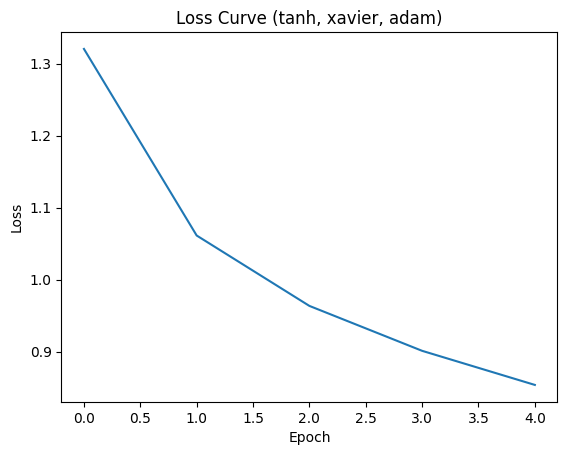


Activation=tanh, Init=xavier, Optimizer=rmsprop


100%|██████████| 782/782 [01:42<00:00,  7.61it/s]


Epoch 1, Loss: 1.4391


100%|██████████| 782/782 [01:42<00:00,  7.63it/s]


Epoch 2, Loss: 1.0685


100%|██████████| 782/782 [01:44<00:00,  7.49it/s]


Epoch 3, Loss: 0.9654


100%|██████████| 782/782 [01:42<00:00,  7.62it/s]


Epoch 4, Loss: 0.9000


100%|██████████| 782/782 [01:45<00:00,  7.43it/s]


Epoch 5, Loss: 0.8507


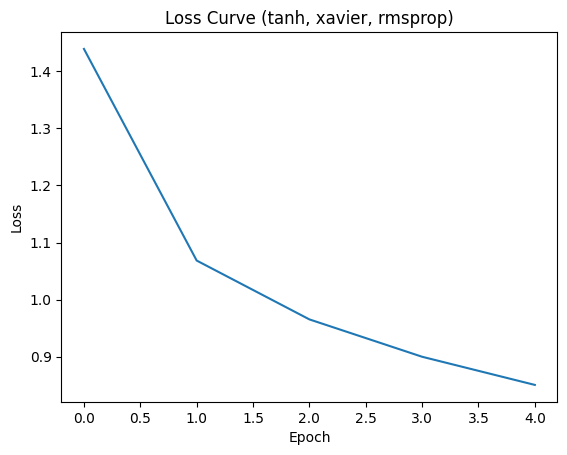


Activation=tanh, Init=kaiming, Optimizer=sgd


100%|██████████| 782/782 [01:40<00:00,  7.75it/s]


Epoch 1, Loss: 1.6512


100%|██████████| 782/782 [01:43<00:00,  7.59it/s]


Epoch 2, Loss: 1.3695


100%|██████████| 782/782 [01:44<00:00,  7.46it/s]


Epoch 3, Loss: 1.2440


100%|██████████| 782/782 [01:44<00:00,  7.48it/s]


Epoch 4, Loss: 1.1620


100%|██████████| 782/782 [01:43<00:00,  7.53it/s]


Epoch 5, Loss: 1.1061


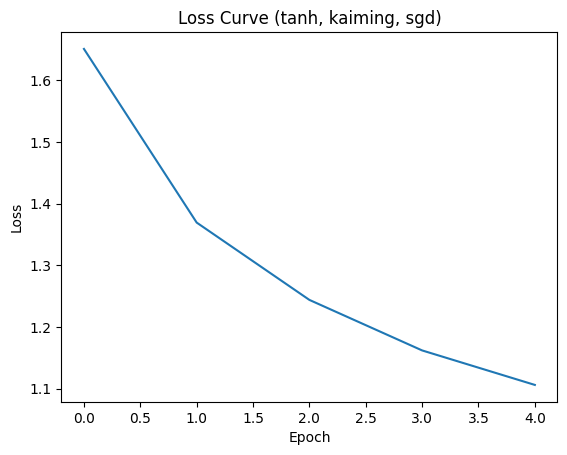


Activation=tanh, Init=kaiming, Optimizer=adam


100%|██████████| 782/782 [01:45<00:00,  7.41it/s]


Epoch 1, Loss: 1.3563


100%|██████████| 782/782 [01:46<00:00,  7.34it/s]


Epoch 2, Loss: 1.0188


100%|██████████| 782/782 [01:46<00:00,  7.36it/s]


Epoch 3, Loss: 0.9304


100%|██████████| 782/782 [01:45<00:00,  7.44it/s]


Epoch 4, Loss: 0.8678


100%|██████████| 782/782 [01:45<00:00,  7.43it/s]


Epoch 5, Loss: 0.8255


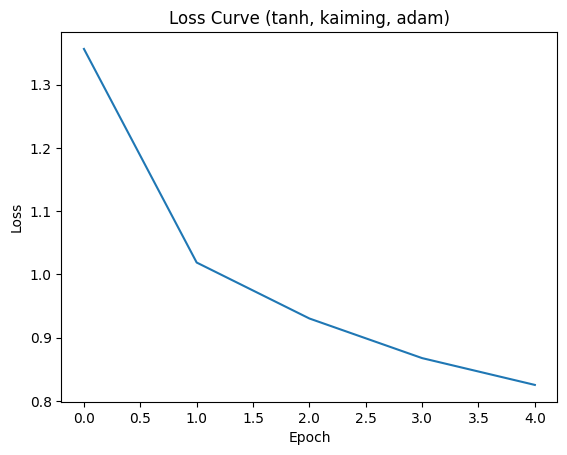


Activation=tanh, Init=kaiming, Optimizer=rmsprop


100%|██████████| 782/782 [01:43<00:00,  7.58it/s]


Epoch 1, Loss: 1.5389


100%|██████████| 782/782 [01:44<00:00,  7.50it/s]


Epoch 2, Loss: 1.1065


100%|██████████| 782/782 [01:44<00:00,  7.51it/s]


Epoch 3, Loss: 0.9852


100%|██████████| 782/782 [01:44<00:00,  7.50it/s]


Epoch 4, Loss: 0.9198


100%|██████████| 782/782 [01:44<00:00,  7.46it/s]


Epoch 5, Loss: 0.8746


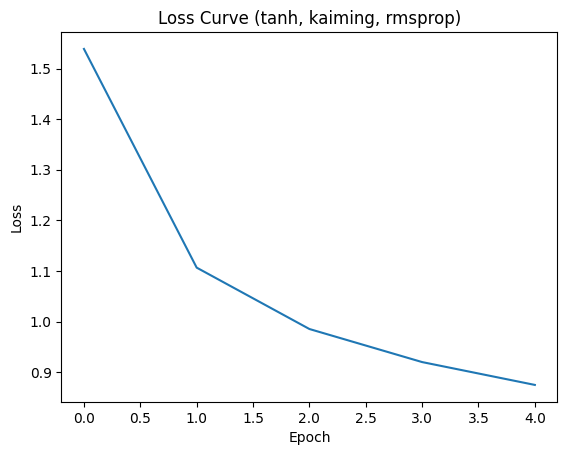


Activation=leakyrelu, Init=random, Optimizer=sgd


100%|██████████| 782/782 [01:31<00:00,  8.58it/s]


Epoch 1, Loss: nan


100%|██████████| 782/782 [01:27<00:00,  8.97it/s]


Epoch 2, Loss: nan


100%|██████████| 782/782 [01:27<00:00,  8.95it/s]


Epoch 3, Loss: nan


100%|██████████| 782/782 [01:28<00:00,  8.87it/s]


Epoch 4, Loss: nan


100%|██████████| 782/782 [01:29<00:00,  8.77it/s]


Epoch 5, Loss: nan


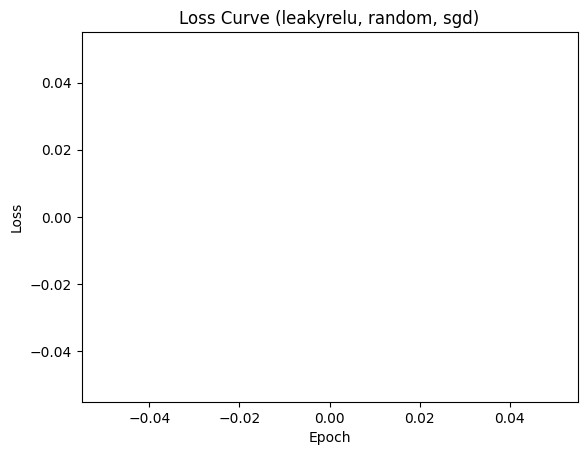


Activation=leakyrelu, Init=random, Optimizer=adam


100%|██████████| 782/782 [01:36<00:00,  8.13it/s]


Epoch 1, Loss: 637379.7603


100%|██████████| 782/782 [01:44<00:00,  7.45it/s]


Epoch 2, Loss: 2873.7575


100%|██████████| 782/782 [01:48<00:00,  7.23it/s]


Epoch 3, Loss: 69.2928


100%|██████████| 782/782 [01:46<00:00,  7.37it/s]


Epoch 4, Loss: 23.5346


100%|██████████| 782/782 [01:41<00:00,  7.70it/s]


Epoch 5, Loss: 12.1383


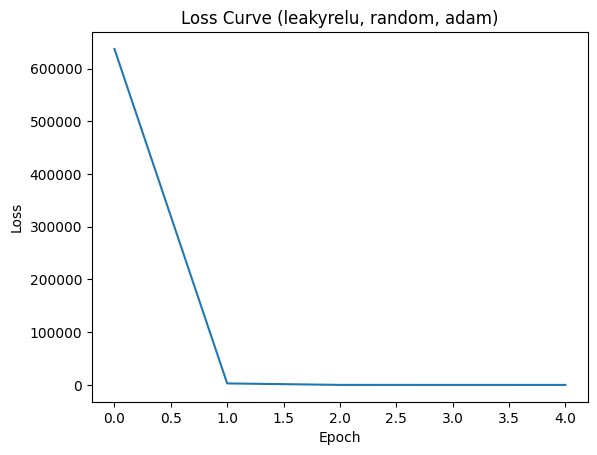


Activation=leakyrelu, Init=random, Optimizer=rmsprop


100%|██████████| 782/782 [01:39<00:00,  7.88it/s]


Epoch 1, Loss: 392561.6686


100%|██████████| 782/782 [01:39<00:00,  7.84it/s]


Epoch 2, Loss: 39.0800


100%|██████████| 782/782 [01:39<00:00,  7.84it/s]


Epoch 3, Loss: 3.0055


100%|██████████| 782/782 [01:39<00:00,  7.84it/s]


Epoch 4, Loss: 2.4274


100%|██████████| 782/782 [01:38<00:00,  7.91it/s]


Epoch 5, Loss: 2.2956


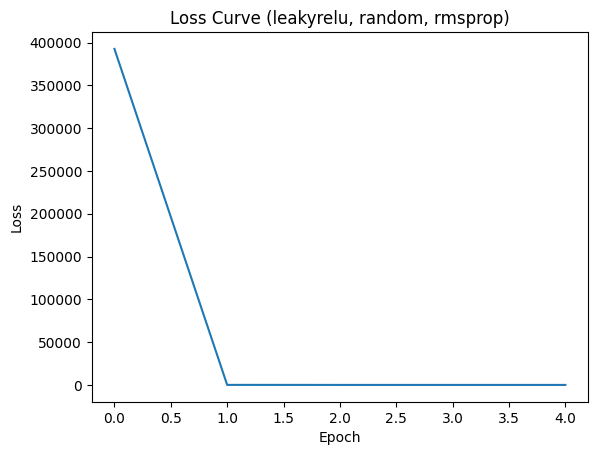


Activation=leakyrelu, Init=xavier, Optimizer=sgd


100%|██████████| 782/782 [01:40<00:00,  7.76it/s]


Epoch 1, Loss: 1.8879


100%|██████████| 782/782 [01:38<00:00,  7.97it/s]


Epoch 2, Loss: 1.5606


100%|██████████| 782/782 [01:37<00:00,  8.01it/s]


Epoch 3, Loss: 1.4244


100%|██████████| 782/782 [01:40<00:00,  7.79it/s]


Epoch 4, Loss: 1.3365


100%|██████████| 782/782 [01:38<00:00,  7.96it/s]


Epoch 5, Loss: 1.2735


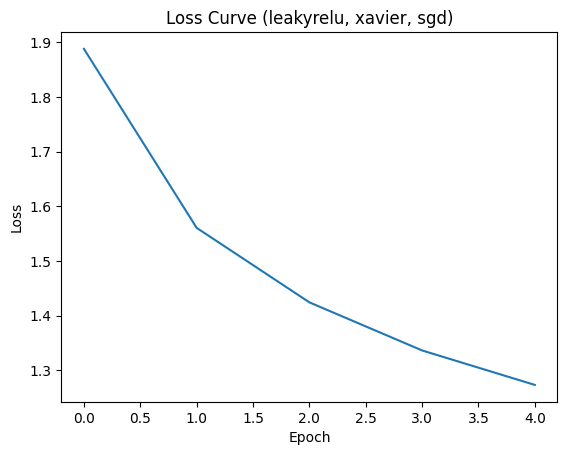


Activation=leakyrelu, Init=xavier, Optimizer=adam


100%|██████████| 782/782 [01:44<00:00,  7.46it/s]


Epoch 1, Loss: 1.3982


100%|██████████| 782/782 [01:42<00:00,  7.61it/s]


Epoch 2, Loss: 1.0325


100%|██████████| 782/782 [01:42<00:00,  7.62it/s]


Epoch 3, Loss: 0.8924


100%|██████████| 782/782 [01:42<00:00,  7.66it/s]


Epoch 4, Loss: 0.8092


100%|██████████| 782/782 [01:43<00:00,  7.54it/s]


Epoch 5, Loss: 0.7410


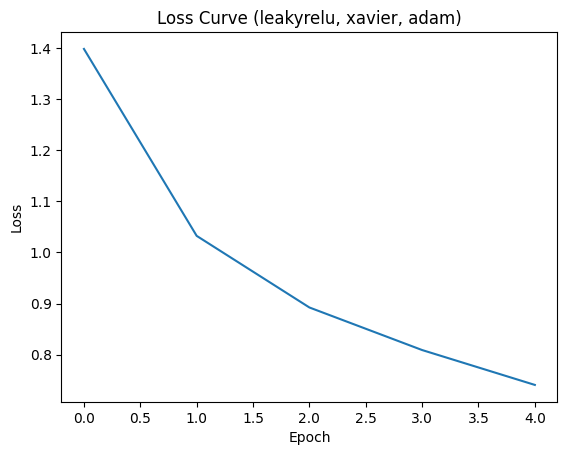


Activation=leakyrelu, Init=xavier, Optimizer=rmsprop


100%|██████████| 782/782 [01:41<00:00,  7.67it/s]


Epoch 1, Loss: 1.4409


100%|██████████| 782/782 [01:42<00:00,  7.62it/s]


Epoch 2, Loss: 1.0270


100%|██████████| 782/782 [01:44<00:00,  7.45it/s]


Epoch 3, Loss: 0.8813


100%|██████████| 782/782 [01:41<00:00,  7.73it/s]


Epoch 4, Loss: 0.7803


100%|██████████| 782/782 [01:40<00:00,  7.79it/s]


Epoch 5, Loss: 0.7027


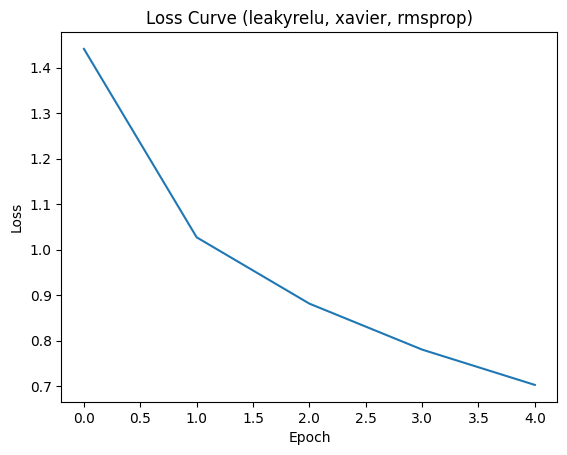


Activation=leakyrelu, Init=kaiming, Optimizer=sgd


100%|██████████| 782/782 [01:41<00:00,  7.72it/s]


Epoch 1, Loss: 1.7550


100%|██████████| 782/782 [01:40<00:00,  7.75it/s]


Epoch 2, Loss: 1.4409


100%|██████████| 782/782 [01:40<00:00,  7.78it/s]


Epoch 3, Loss: 1.3157


100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch 4, Loss: 1.2372


100%|██████████| 782/782 [01:40<00:00,  7.81it/s]


Epoch 5, Loss: 1.1717


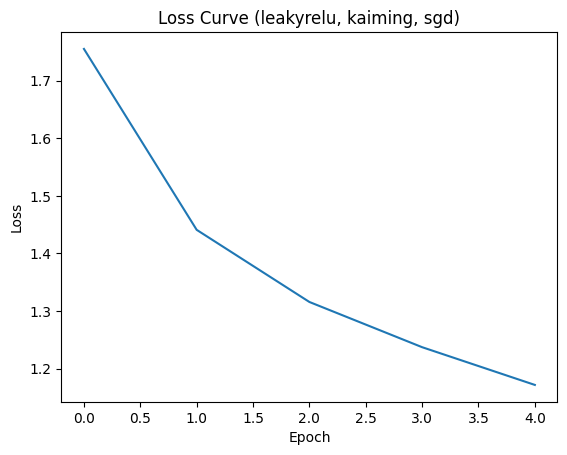


Activation=leakyrelu, Init=kaiming, Optimizer=adam


100%|██████████| 782/782 [01:44<00:00,  7.46it/s]


Epoch 1, Loss: 1.4388


100%|██████████| 782/782 [01:42<00:00,  7.59it/s]


Epoch 2, Loss: 1.0500


100%|██████████| 782/782 [01:42<00:00,  7.60it/s]


Epoch 3, Loss: 0.9088


100%|██████████| 782/782 [01:44<00:00,  7.47it/s]


Epoch 4, Loss: 0.8249


100%|██████████| 782/782 [01:43<00:00,  7.52it/s]


Epoch 5, Loss: 0.7486


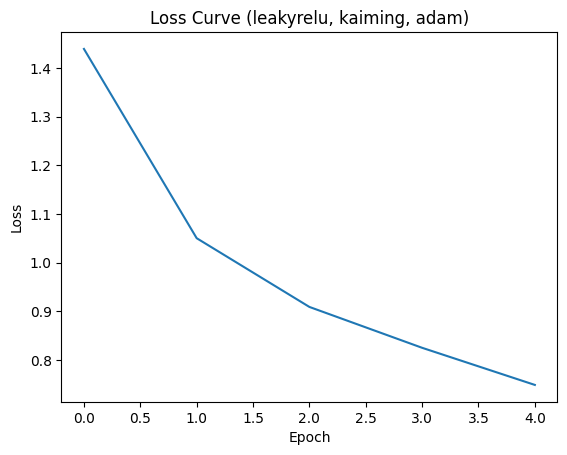


Activation=leakyrelu, Init=kaiming, Optimizer=rmsprop


100%|██████████| 782/782 [01:43<00:00,  7.57it/s]


Epoch 1, Loss: 1.5097


100%|██████████| 782/782 [01:43<00:00,  7.59it/s]


Epoch 2, Loss: 1.0537


100%|██████████| 782/782 [01:43<00:00,  7.59it/s]


Epoch 3, Loss: 0.8925


100%|██████████| 782/782 [01:42<00:00,  7.64it/s]


Epoch 4, Loss: 0.7919


100%|██████████| 782/782 [01:42<00:00,  7.63it/s]


Epoch 5, Loss: 0.7091


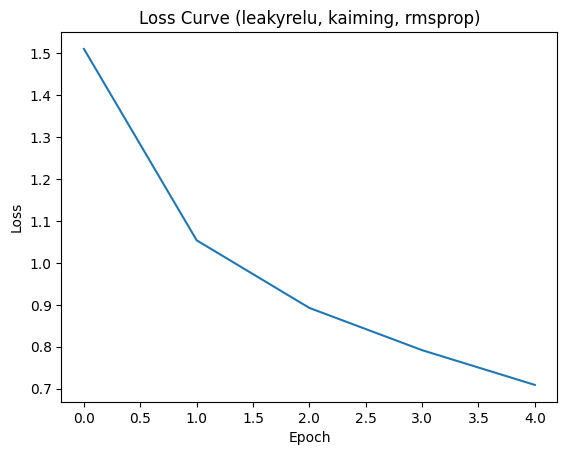

In [11]:
activations = ["relu", "tanh", "leakyrelu"]
inits = ["random", "xavier", "kaiming"]
opts = ["sgd", "adam", "rmsprop"]

results = []

for act in activations:
    for init in inits:
        for opt_name in opts:
            print(f"\nActivation={act}, Init={init}, Optimizer={opt_name}")

            model = CNN(act).to(device)
            init_weights(model, init)

            if opt_name == "sgd":
                optimizer = optim.SGD(model.parameters(), lr=0.01)
            elif opt_name == "adam":
                optimizer = optim.Adam(model.parameters(), lr=0.001)
            elif opt_name == "rmsprop":
                optimizer = optim.RMSprop(model.parameters(), lr=0.001)

            criterion = nn.CrossEntropyLoss()

            losses = train_model(model, optimizer, criterion)
            acc = evaluate_model(model)

            results.append((act, init, opt_name, acc))

            # Visual: Loss Curve
            plt.figure()
            plt.plot(losses)
            plt.title(f"Loss Curve ({act}, {init}, {opt_name})")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.show()


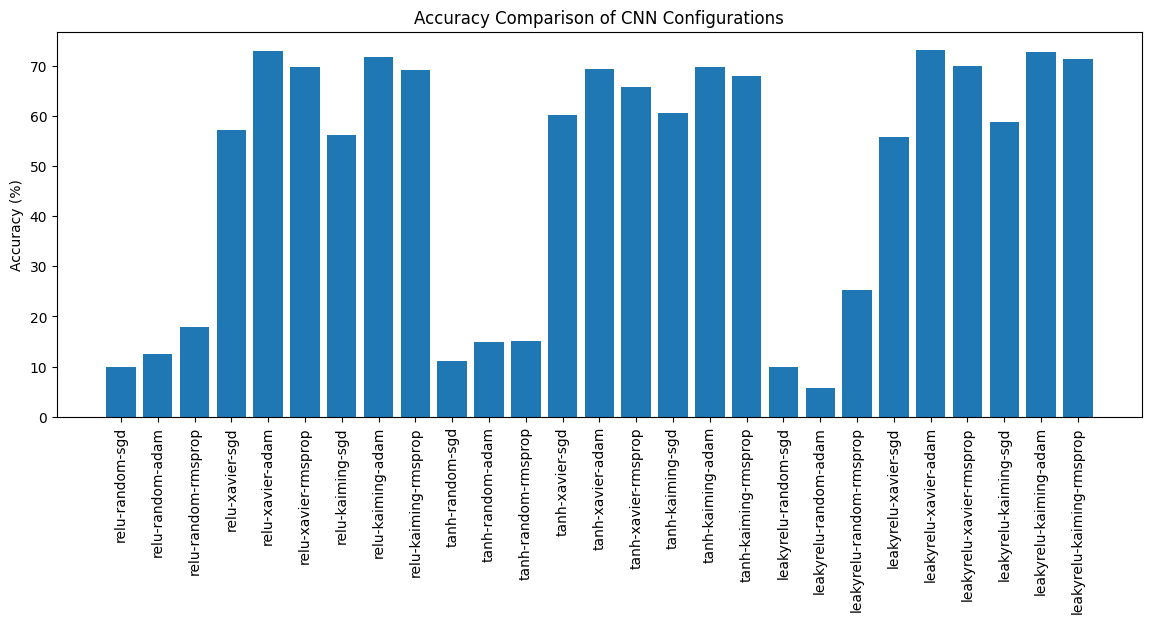

In [12]:
labels = [f"{a}-{i}-{o}" for a,i,o,_ in results]
accs = [r[3] for r in results]

plt.figure(figsize=(14,5))
plt.bar(labels, accs)
plt.xticks(rotation=90)
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison of CNN Configurations")
plt.show()


In [13]:
best = max(results, key=lambda x: x[3])
print("Best CNN:", best)


Best CNN: ('leakyrelu', 'xavier', 'adam', 73.11)


In [14]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = resnet.to(device)

optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_model(resnet, optimizer, criterion)
resnet_acc = evaluate_model(resnet)
print("ResNet-18 Accuracy:", resnet_acc)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]
100%|██████████| 782/782 [15:01<00:00,  1.15s/it]


Epoch 1, Loss: 0.9888


 27%|██▋       | 208/782 [03:50<10:35,  1.11s/it]


KeyboardInterrupt: 

In [16]:
resnet_acc = evaluate_model(resnet)
print("ResNet-18 Accuracy:", resnet_acc)


ResNet-18 Accuracy: 77.59


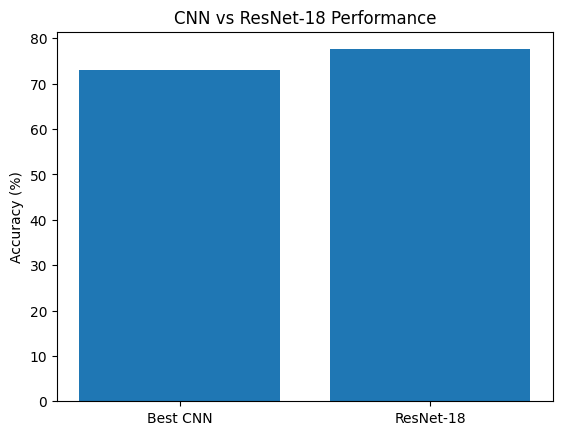

In [17]:
plt.figure()
plt.bar(["Best CNN", "ResNet-18"], [best[3], resnet_acc])
plt.ylabel("Accuracy (%)")
plt.title("CNN vs ResNet-18 Performance")
plt.show()
